In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from scipy import stats

# read in my plot parameters
pp = pd.read_csv('plotparams.csv',index_col=0)

# Notebook 6: weathering mass balance

This notebook evaluates the Luquillo Mountains study watersheds in terms of rock mass balance using the approach of West et al., (2005) and contrasts the apparent "supply limitation" with predictions of increased weathering from C-Q relationships reported in Wymore et al., (2017). Then, we compare how predictions based on short-term F$_{\mathrm{yw}}$-Q relationships and longer-term watershed average F$_{\mathrm{yw}}$-MAP relationships might adhere to the supply limited constraint.  

In [2]:
# read in isotope results with spatial data appended (really just need Qmean)
df = pd.read_csv('data/WRR2025_fyw_spatial.csv',index_col=0)
# and flow percentiles too
perc_df = pd.read_csv('tables/WRR2025_flowbins_output.csv',index_col=0)
# read in all CQ data
cq = pd.read_csv('data/WRR2025_cq.csv',parse_dates=['datetime'],low_memory=False)
# read in only CQ data from the isotope sample period (2018-2020)
cq_sp = pd.read_csv('data/WRR2025_cq_sp.csv',index_col=0)
# read in discharge bin medians
df_medians = pd.read_csv('data/WRR2025_discharge_medians.csv',index_col=0)
# Wymore 2017 data: dwdf is Damkohler number (Dw) numbers for Si (Table 4)
dwdf = pd.read_csv('downloaded/Wymore2017Table4_Si.csv',index_col=0)
# data from West et al., (2005) includes silicate cation denudation, total denudation
westdata = pd.read_csv('downloaded/West2005table2.csv',index_col=0)
# remove west data Icacos entries because we use new data
westdata = westdata.drop(['PR Long Term','PR Modern Day'],axis=0)

# MPR ampratio is normalized to EV precip, need to convert to PDE
df.loc['MPR','ampratio'] = df.loc['MPR','ampratio']*3.49/2.5
# percentiles too
perc_df.loc[perc_df['site']=='MPR','ampratio'] = perc_df.loc[perc_df['site']=='MPR','ampratio']*3.49/2.5 # re-normalize MPR Fyw to PDE (As = 2.50) rather than EV (As = 3.49)

# q and area data from Wymore table 1
Q_dict = {'MPR':1595,
         'RI':412,
         'QS':290,
         'QG':13}
area_dict = {'MPR':17.7,
            'RES4':22.4,
            'QS':2.6,
            'RI':3.3,
            'QG':0.13,
            'QP':0.31,
            'Q3':0.28,
            'RP':40.14}

# molar masses
mm = {'Na':22.989,
     'Ca':40.078,
     'K':39.0983,
     'Mg':24.305,
     'Cl':35.453}
# molar masses of oxides Na2O, CaO, K2O, MgO
mmox = {'Na':61.9789,
       'Ca':56.0774,
       'K':94.2,
       'Mg':40.3044,
       'CO2':44.009}

In [3]:
## function for weighted mean error propagation from a Kirchner lecture 
## "Data Analysis Toolkit #12: Weighted averages and their uncertainties"
def weightederror(c,w):
    ans = np.sum(c*w)/np.sum(w)
    left = np.sum(w*(c**2))/np.sum(w)-ans**2
    right = np.sum(w**2)/((np.sum(w)**2)-np.sum(w**2))
    stderror = np.sqrt(left*right)
    return [ans,stderror]

In [4]:
### calculate discharge weighted C
# remember solute data are in mg/L and we are using molar ratios to transform
cq['Na*'] = cq['Na']-0.8525*(mm['Na']/mm['Cl'])*cq['Cl']
cq['Mg*'] = cq['Mg']-0.09689*(mm['Mg']/mm['Cl'])*cq['Cl']
cq['Ca*'] = cq['Ca']-0.01876*(mm['Ca']/mm['Cl'])*cq['Cl']
cq['K*'] = cq['K']-0.01790*(mm['K']/mm['Cl'])*cq['Cl']

# make sure all are greater than 0
cq = cq[(cq[['Na*','Mg*','Ca*','K*']] > 0).all(axis=1)]

# for Rio Icacos, assume no carbonate input, so silicate cation = total cation
cq.loc[cq['Sample_ID']=='RI','Ca_sil'] = cq.loc[cq['Sample_ID']=='RI','Ca*']
cq.loc[cq['Sample_ID']=='RI','Mg_sil'] = cq.loc[cq['Sample_ID']=='RI','Mg*']
cq.loc[cq['Sample_ID']=='RI','K_sil'] = cq.loc[cq['Sample_ID']=='RI','K*']
cq.loc[cq['Sample_ID']=='RI','Na_sil'] = cq.loc[cq['Sample_ID']=='RI','Na*']

# for MPR
# MPR Ca/Na = 3.33 from Moore et al., (2024)
# Mg/Na = 1.12
cq.loc[cq['Sample_ID']=='MPR','Ca_sil'] = cq.loc[cq['Sample_ID']=='MPR','Na*']*3.33
cq.loc[cq['Sample_ID']=='MPR','Mg_sil'] = cq.loc[cq['Sample_ID']=='MPR','Na*']*1.12
cq.loc[cq['Sample_ID']=='MPR','K_sil'] = cq.loc[cq['Sample_ID']=='MPR','K*']
cq.loc[cq['Sample_ID']=='MPR','Na_sil'] = cq.loc[cq['Sample_ID']=='MPR','Na*']

## cant have Fsil >1, make sure Ca_sil does not exceed Ca_total
cq.loc[cq['Ca_sil']>cq['Ca*'],'Ca_sil'] = cq['Ca*']
cq.loc[cq['Mg_sil']>cq['Mg*'],'Mg_sil'] = cq['Mg*']

### now carb-derived Ca and Mg
# for MPR
cq.loc[cq['Sample_ID']=='MPR','Ca_carb'] = cq.loc[cq['Sample_ID']=='MPR','Ca*']-cq.loc[cq['Sample_ID']=='MPR','Ca_sil'] 
cq.loc[cq['Sample_ID']=='MPR','Mg_carb'] = cq.loc[cq['Sample_ID']=='MPR','Mg*']-cq.loc[cq['Sample_ID']=='MPR','Mg_sil'] 


### begin calculating weighted concentrations
sitelist = ['RI','MPR']
elementlist_MPR = ['Na*','Ca*','Mg*','K*','Na_sil','Ca_sil','Mg_sil','K_sil','SiO2','Ca_carb','Mg_carb']
elementlist_RI = ['Na*','Ca*','Mg*','K*','Na_sil','Ca_sil','Mg_sil','K_sil','SiO2'] # assume no carb in RI

meancs = pd.DataFrame(index=sitelist)
for s in sitelist:
    temp = cq.loc[cq['Sample_ID']==s,:]
    temp = temp.dropna(subset=['Na_sil','Ca_sil','Mg_sil','K_sil','SiO2'])
    
    if s=='RI':
        elementlist = elementlist_RI
    else:
        elementlist = elementlist_MPR
    
    for e in elementlist:
        # calculate weighted c and sterror
        tempc = temp.loc[(temp[e]>0) & (~np.isnan(temp['discharge(m/yr)']))]
        [tempc_w,tempc_ste] = weightederror(tempc[e],tempc['discharge(m/yr)'])
        # save to df
        meancs.loc[s,e] = tempc_w
        meancs.loc[s,e+'_err'] = tempc_ste
        
    # calculate the sum of silicate-derived cations    
    catsum = np.sum(meancs.loc[s,['Na_sil','Ca_sil','Mg_sil','K_sil']])
    catsum_err = np.sqrt(np.sum([meancs.loc[s,ee+'_err']**2 for ee in ['Na_sil','Ca_sil','Mg_sil','K_sil']]))
    
    # carbonate CO2 1:1 molar ratio to Ca/Mg -> 
    if (s in ['RI','QG']):
        carboxidesum = 0
    else:
        carboxidesum = (meancs.loc[s,'Ca_carb']/mm['Ca']+meancs.loc[s,'Mg_carb']/mm['Mg'])*mmox['CO2']
    
    # calculate oxide sum 
    oxidesum = meancs.loc[s,'Na*']*mmox['Na']/(2*mm['Na'])+meancs.loc[s,'Ca*']*mmox['Ca']/mm['Ca']+meancs.loc[s,'Mg*']*mmox['Mg']/mm['Mg']+meancs.loc[s,'K*']*mmox['K']/(2*mm['K'])+meancs.loc[s,'SiO2']+carboxidesum
    
    meancs.loc[s,'catsum'] = catsum
    meancs.loc[s,'catsum_err'] =catsum_err
    meancs.loc[s,'oxidesum'] = oxidesum

In [5]:
# create dataframe for watershed fluxes and add erosion data
fluxes = pd.DataFrame()

## Erosion for MPR from Moore 2024
# MPR = A1 = 248+/-57
fluxes.loc['MPR','E'] = 248
fluxes.loc['MPR','E_err'] = 57

# add erosion for RI from Brocard 2015 55+/-4, 57.9 +/- 3.2
mma = np.mean([55,57.9]) # in meters per million years
mma_err = np.sqrt((4/55)**2+(3.2/57.9)**2)*mma # error
# m/Ma to km/a
kma = mma/1e6
kma_err = mma_err/1e6

# density of rock 2700 kg/m^3
fluxes.loc['RI','E'] = kma*2.7*1e6 # kg/m^3 to metric tons/km^3 times km / year = metric tons / km^2 / year
fluxes.loc['RI','E_err'] = kma_err*2.7*1e6 

In [6]:
### calculate load for SCDR and CWR from Q-weighted C times mean Q
## mg/s to metric tons/yr 0.031536

for s in ['RI','MPR']:
    mgpers = meancs.loc[s,'catsum']*Q_dict[s]
    mgpers_err = meancs.loc[s,'catsum_err']*Q_dict[s]
    
    # oxide
    mgpers_ox = meancs.loc[s,'oxidesum']*Q_dict[s]
    
    tonsperyear = mgpers*0.031536    
    tonsperyear_err = mgpers_err*0.031536
    
    tonsperyear_ox = mgpers_ox*0.031536
    
    tonsperyearkm = tonsperyear/area_dict[s]
    tonsperyearkm_err = tonsperyear_err/area_dict[s]
    
    tonsperyearkm_ox = tonsperyear_ox/area_dict[s]
    
    fluxes.loc[s,'SCDR']= tonsperyearkm
    fluxes.loc[s,'SCDR_err'] =tonsperyearkm_err
    
    fluxes.loc[s,'CWR'] = tonsperyearkm_ox
    
    
### add 20% to SCDR to match with West 2005 data
fluxes['SCDR_err'] = 0.2*fluxes['SCDR']
fluxes['CWR_err'] = 0.2*fluxes['CWR']

In [7]:
### better to use LOADEST, avaiable for RI and MPR from Stallard chapter 
# "Weathering, Landscape Equilibrium, and Carbon in Four Watersheds in Eastern Puerto Rico" 2012
# Table 3 under "bedrock-derived yields"
# conveniently, these results are already corrected for rain contributions
# and they calculate "dissolved bedrock yield" DBRx which represents the mass flux of the cation-oxides 
# (e.g. Na2O) along with SiO2. This equals the CWR for RI, where carbonate weathering is insigificant
# for MPR, we need just need to modify the reported DBRx to add back the CO2-carbonate mass

stallard_ri = {'Na':235,
              'K':47.7,
              'Mg':93,
              'Ca':246,
              'DBRx':78} # in kmol/km^2 / yr

stallard_mpr = {'Na':173,
              'K':41,
              'Mg':122,
              'Ca':422,
               'DBRx':87.3} # in kmol/km^2 / yr

## RI is easy, not carbonate correction
# multiply kmol/km^2/yr by molar mass to get kg/km^2/yr, sum, divide by 1000 for kg/km2/yr to metric tons/km2/yr
fluxes.loc['RI','SCDR_loadest'] = np.sum([stallard_ri[e]*mm[e] for e in ['Na','K','Mg','Ca']])/1000

# CWR reported as DBRx
fluxes.loc['RI','CWR_loadest'] = stallard_ri['DBRx']

### now MPR we need to subtract the carbonate fraction
## convert kmol/km^2/yr to metric tons/km^2/yr for individual cation fluxes
mpr_na = (stallard_mpr['Na']*mm['Na'])/1000
mpr_k = (stallard_mpr['K']*mm['K'])/1000
mpr_ca = (stallard_mpr['Ca']*mm['Ca'])/1000
mpr_mg = (stallard_mpr['Mg']*mm['Mg'])/1000

# calculate silicate-derived Ca and Mg from ratios to Na 
# if silicate-derived is bigger than tota, can't have Fsil>1, so set equal to total
mpr_ca_sil = np.min([mpr_na*3.33,mpr_ca])
mpr_mg_sil = np.min([mpr_na*1.12,mpr_mg]) 
# for carbonate, subtract Ca or Mg silicate from total Ca or Mg, can't have less than 0
mpr_ca_carb = mpr_ca-mpr_ca_sil
mpr_mg_carb = mpr_mg-mpr_mg_sil

# CO2 sum from carbonate stoich, West et al., (2005)
mpr_carboxide = (mpr_ca_carb/mm['Ca']+mpr_mg_carb/mm['Mg'])*mmox['CO2']

# record into dataframe
fluxes.loc['MPR','SCDR_loadest'] = mpr_na+mpr_k+mpr_ca_sil+mpr_mg_sil
fluxes.loc['MPR','CWR_loadest'] = stallard_mpr['DBRx']+mpr_carboxide

# add 20% error for SCDR
fluxes['SCDR_loadest_err'] = 0.2*fluxes['SCDR_loadest']
fluxes['CWR_loadest_err'] = 0.2*fluxes['CWR_loadest']

# calc TDR for those
fluxes['TDR_loadest'] = fluxes['CWR_loadest']+fluxes['E']
fluxes['TDR_loadest_err'] = np.sqrt(fluxes['CWR_loadest_err']**2+fluxes['E_err']**2)

fluxes['TDR'] = fluxes['CWR']+fluxes['E']
fluxes['TDR_err'] = np.sqrt(fluxes['CWR_err']**2+fluxes['E_err']**2)


fluxes

,E,E_err,SCDR,SCDR_err,CWR,CWR_err,SCDR_loadest,CWR_loadest,SCDR_loadest_err,CWR_loadest_err,TDR_loadest,TDR_loadest_err,TDR,TDR_err
MPR,248.000,57.000000,13.394242,2.678848,46.752411,9.350482,21.789070,91.32907,4.357814,18.265814,339.32907,59.855158,294.752411,57.761852
RI,152.415,13.922237,10.449225,2.089845,31.753312,6.350662,19.386957,78.00000,3.877391,15.600000,230.41500,20.909057,184.168312,15.302274


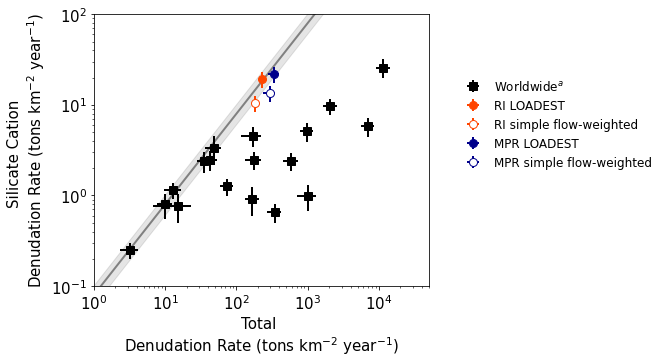

In [8]:
###
plt.rcParams.update({'font.size': 15,
                    'axes.labelsize': 15,
                    'xtick.labelsize':15,
                    'ytick.labelsize':15,
                    'lines.linewidth':2})
fig,ax=plt.subplots(1,1,figsize=(6,5)) 

# West 2005 data
plt.errorbar(westdata['TDR'],westdata['SCDR'],xerr=westdata['TDR_err'],yerr=westdata['SCDR_err'],
             c='k',ls='',marker='s',markersize=8,elinewidth=2)

sitelist = ['RI','MPR']
for s in sitelist:
    plt.errorbar(fluxes.loc[s,'TDR_loadest'],fluxes.loc[s,'SCDR_loadest'],xerr=fluxes.loc[s,'TDR_loadest_err'],yerr=fluxes.loc[s,'SCDR_loadest_err'],
         ls='',marker='o',color=pp.color[s],markersize=8,elinewidth=2,zorder=2)

    plt.errorbar(fluxes.loc[s,'TDR'],fluxes.loc[s,'SCDR'],xerr=fluxes.loc[s,'TDR_err'],yerr=fluxes.loc[s,'SCDR_err'],
                 ls='',marker='o',color=pp.color[s],markerfacecolor='w',markersize=8,elinewidth=2,zorder=1)

plt.xscale('log')
plt.yscale('log')

# plot supply limited zone (0.08+/-0.02 1sigma) 
plotx = np.array([0.1,1,10,100,1000,50000])
ploty1 = 0.06*plotx
ploty2 = 0.10*plotx
plt.plot(plotx,0.08*plotx,c='gray',zorder=1,label='_nolegend_')
plt.fill_between(plotx,ploty1,ploty2,alpha=0.1,color='k',zorder=0,label='_nolegend_')

# lims, labels
plt.ylim([0.1,1e2])
plt.xlim([1,5e4])

plt.ylabel('Silicate Cation \nDenudation Rate (tons km$^{-2}$ year$^{-1}$)')

plt.xlabel('Total \nDenudation Rate (tons km$^{-2}$ year$^{-1}$)')

plt.legend(['Worldwide$^{a}$','RI LOADEST','RI simple flow-weighted','MPR LOADEST','MPR simple flow-weighted'],frameon=False,fontsize=12,ncol=1,bbox_to_anchor=[1.7,0.8])

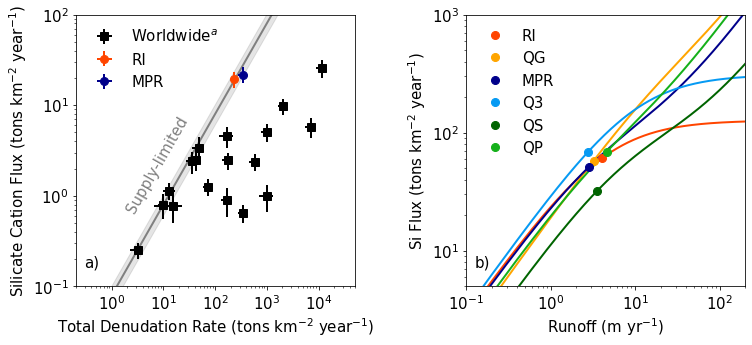

In [9]:
### now make a plot including predictions from C-Q relationships
plt.rcParams.update({'font.size': 15,
                    'axes.labelsize': 15,
                    'xtick.labelsize':15,
                    'ytick.labelsize':15,
                    'lines.linewidth':2})
fig,ax=plt.subplots(1,2,figsize=(12,5))#,constrained_layout=True) 

sitelist=['RI','MPR']

## subplot a: mass balance
# plot West 2005 data
ax[0].errorbar(westdata['TDR'],westdata['SCDR'],xerr=westdata['TDR_err'],yerr=westdata['SCDR_err'],
             c='k',ls='',marker='s',markersize=8,elinewidth=2)
# plot RI and MPR data
for s in sitelist:
    ax[0].errorbar(fluxes.loc[s,'TDR_loadest'],fluxes.loc[s,'SCDR_loadest'],xerr=fluxes.loc[s,'TDR_loadest_err'],yerr=fluxes.loc[s,'SCDR_loadest_err'],
                 ls='',marker='o',color=pp.color[s],markersize=8,elinewidth=2)

ax[0].set_xscale('log')
ax[0].set_yscale('log')

# plot supply limited zone (0.08+/-0.02 1sigma) 
plotx = np.array([0.1,1,10,100,1000,50000])
ploty1 = 0.06*plotx
ploty2 = 0.10*plotx
ax[0].plot(plotx,0.08*plotx,c='gray',zorder=1,label='_nolegend_')
ax[0].fill_between(plotx,ploty1,ploty2,alpha=0.1,color='k',zorder=0,label='_nolegend_')

## subplot b: C-Q predictions using Damkohler (Dw) model
def dwmodel(q,dw,cmax,c0):
    result = c0/(1+dw/q) + cmax*(dw/q)/(1+dw/q)
    return result
    
plotxb = np.arange(0.1,500,0.1)  

for s in ['RI','QG','MPR','Q3','QS','QP']:
    if s=='RI':
        label1 = 'Wymore model'
        label2 = 'Fyw model'
    else:
        label1 = '_nolegend_'
        label2 = '_nolegend_'
    
    [dw,cmax,c0] =dwdf.loc[s,['Dw','Cmax','C0']].values
    
    meanq = df.loc[s,'Qmean']/1000
    meanc1 = dwmodel(meanq,dw,cmax,c0)
    j1 = meanq*meanc1

    # plot whole J-Q (from C-Q) relationship
    ax[1].plot(plotxb,(dwmodel(plotxb,dw,cmax,c0)*plotxb),c=pp.color[s],zorder=0,label='_nolegend_')

    # plot at modern mean Q
    ax[1].plot(meanq,((meanc1*meanq)),c=pp.color[s],ls='',marker='o',markersize=8)
    
  
# limits, labels

ax[0].set_ylim([0.1,1e2])
ax[0].set_xlim([0.2,5e4])

ax[1].set_xscale('log')
ax[1].set_yscale('log')

ax[1].set_ylim([5,1000])
ax[1].set_xlim([0.1,200])

ax[0].set_ylabel('Silicate Cation Flux (tons km$^{-2}$ year$^{-1}$)')
ax[0].set_xlabel('Total Denudation Rate (tons km$^{-2}$ year$^{-1}$)')
ax[0].legend(['Worldwide$^{a}$','RI','MPR','QS'],frameon=False,fontsize=15,loc='upper left')

ax[1].set_ylabel('Si Flux (tons km$^{-2}$ year$^{-1}$)')
ax[1].set_xlabel('Runoff (m yr$^{-1}$)')
ax[1].legend(['RI','QG','MPR','Q3','QS','QP'],frameon=False,ncol=1)

# panel labels
labels = ['a)','b)','c)','d)']
[ax[i].text(0.03,0.07,labels[i],transform=ax[i].transAxes) for i in range(0,2)]

### label suply limit with diagonal text...
plotxa = np.array([0.1,1,10,100,1000,50000])
ploty1 = 0.06*plotxa
ploty2 = 0.10*plotxa

xyfrom = [np.log10(0.1),np.log10(0.2)]
xyto = [np.log10(1e4),np.log10(1e2)]

midx = 10
midy=2

text = 'Supply-limited'

dx = xyto[0] - xyfrom[0]
dy = xyto[1] - xyfrom[1]
rotn = np.degrees(np.arctan2(dy, dx)) # not the transformed p2 and p1

ax[0].text(midx, midy, text, ha='center', va='bottom', color='gray',
        rotation=rotn-17, rotation_mode='anchor', transform_rotates_text=True)

fig.subplots_adjust(wspace=0.4)

plt.savefig('plots/Fig2_supplylimit.pdf')

In [10]:
# what percent increase in weathering is allowable given cation concentrations in silicate rock?
frac_ri_low = (fluxes.loc['RI','SCDR_loadest']-fluxes.loc['RI','SCDR_loadest_err'])/((fluxes.loc['RI','TDR_loadest']+fluxes.loc['RI','TDR_loadest_err']))
frac_ri_high = (fluxes.loc['RI','SCDR_loadest']+fluxes.loc['RI','SCDR_loadest_err'])/((fluxes.loc['RI','TDR_loadest']-fluxes.loc['RI','TDR_loadest_err']))
frac_ri = ((fluxes.loc['RI','SCDR_loadest']))/(fluxes.loc['RI','TDR_loadest'])

frac_mpr_low = (fluxes.loc['MPR','SCDR_loadest']-fluxes.loc['MPR','SCDR_loadest_err'])/((fluxes.loc['MPR','TDR_loadest']+fluxes.loc['MPR','TDR_loadest_err']))
frac_mpr_high = (fluxes.loc['MPR','SCDR_loadest']+fluxes.loc['MPR','SCDR_loadest_err'])/((fluxes.loc['MPR','TDR_loadest']-fluxes.loc['MPR','TDR_loadest_err']))
frac_mpr = ((fluxes.loc['MPR','SCDR_loadest']))/(fluxes.loc['MPR','TDR_loadest'])


frac_ri = ((fluxes.loc['RI','SCDR_loadest']))/(fluxes.loc['RI','TDR_loadest'])
frac_ri_err = frac_ri*np.sqrt((fluxes.loc['RI','SCDR_loadest_err']/fluxes.loc['RI','SCDR_loadest'])**2+(fluxes.loc['MPR','TDR_loadest_err']/fluxes.loc['MPR','TDR_loadest'])**2)

frac_mpr = ((fluxes.loc['MPR','SCDR_loadest']))/(fluxes.loc['MPR','TDR_loadest'])
frac_mpr_err = frac_mpr*np.sqrt((fluxes.loc['MPR','SCDR_loadest_err']/fluxes.loc['MPR','SCDR_loadest'])**2+(fluxes.loc['MPR','TDR_loadest_err']/fluxes.loc['MPR','TDR_loadest'])**2)

print('Dividing silicate cation denudation rate by total denudation rate:')
print(f'RI SCDR/TDR is {round(frac_ri,3)} +/- {round(frac_ri_err,3)}')
print(f'MPR SCDR/TDR is {round(frac_mpr,3)} +/- {round(frac_mpr_err,3)}')

Dividing silicate cation denudation rate by total denudation rate:
RI SCDR/TDR is 0.084 +/- 0.022
MPR SCDR/TDR is 0.064 +/- 0.017


In [11]:
# what percent increase in weathering is allowable given cation concentrations in silicate rock?
ri_bedrock = 0.0916 # from Turner et al., 2003

print('From cation concentrations in Icacos bedrock reported in Turner et al., (2003):')
print(f'Max weathering is {round(ri_bedrock/frac_ri,2)}x ({round(ri_bedrock/(frac_ri+frac_ri_err),2)}-{round(ri_bedrock/(frac_ri-frac_ri_err),2)}x) modern in RI')
print('From cation concentrations in MPR silicate bedload clasts reported in Moore et al., (2024):')
print(f'Max weathering is {round(0.08/frac_mpr,2)}x ({round(0.08/(frac_mpr+frac_mpr_err),2)}-{round(0.099/(frac_mpr-frac_mpr_err),2)}x) modern in MPR')

From cation concentrations in Icacos bedrock reported in Turner et al., (2003):
Max weathering is 1.09x (0.86-1.48x) modern in RI
From cation concentrations in MPR silicate bedload clasts reported in Moore et al., (2024):
Max weathering is 1.25x (0.98-2.1x) modern in MPR


In [12]:
# From panel b, RI has a "flux plateau" - how much is the maximum weathering flux inferred from C-Q
sitelist = ['RI','QG','MPR','QS','QP']
for s in sitelist:
    
    [dw,cmax,c0] =dwdf.loc[s,['Dw','Cmax','C0']].values
    
    c0=0 # set C0 to zero to see something
    
    meanq = df.loc[s,'Qmean']/1000
    meanc1 = dwmodel(meanq,dw,cmax,c0)
    j1 = meanq*meanc1
    maxflux = np.max(dwmodel(plotxb,dw,cmax,c0)*plotxb)

    print(f'Max Si flux for {s} predicted by C-Q is {round(maxflux,2)} tons/km2/year which is {round(maxflux/j1,1)}x modern rates')

Max Si flux for RI predicted by C-Q is 126.05 tons/km2/year which is 2.1x modern rates
Max Si flux for QG predicted by C-Q is 405.82 tons/km2/year which is 7.4x modern rates
Max Si flux for MPR predicted by C-Q is 113.29 tons/km2/year which is 2.5x modern rates
Max Si flux for QS predicted by C-Q is 97.21 tons/km2/year which is 3.2x modern rates
Max Si flux for QP predicted by C-Q is 107.72 tons/km2/year which is 2.0x modern rates


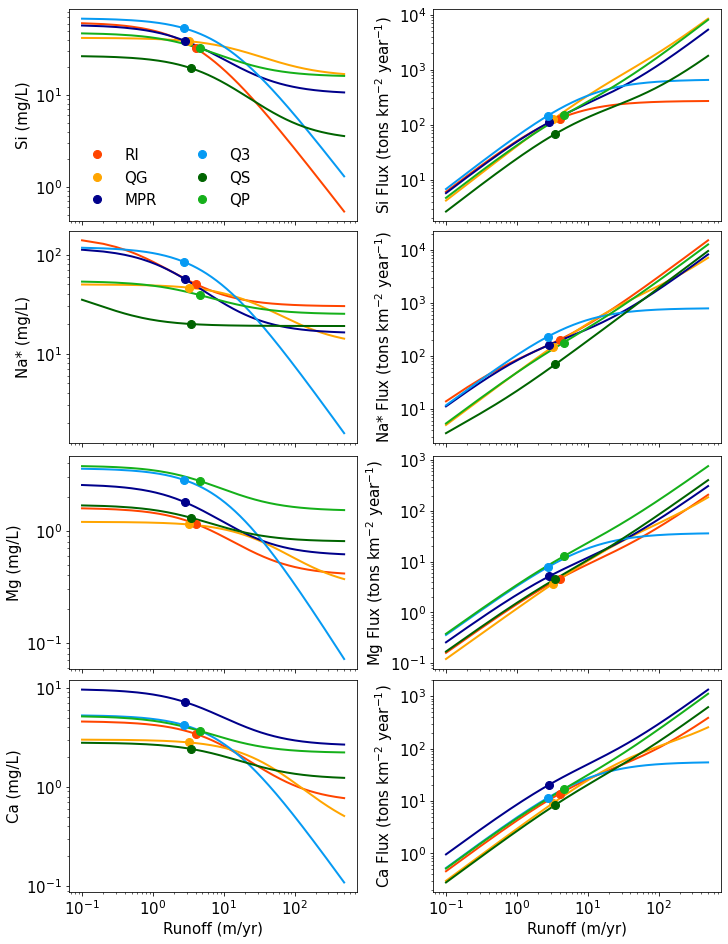

In [13]:
### now iterate through all 4 Dw weathering models to see if Si has different behavior from cations
# Wymore 2017 data: dwdf is Damkohler number (Dw) numbers for Si (Table 4)

fig,ax=plt.subplots(4,2,constrained_layout=True,figsize=(10,13),sharex=True)
ax=ax.flatten()

molarmasscorr = [28.09/60.08,1,1,1] # plot in mg/L of element, data for SiO2 reported as mg SiO2/L, convert to mg Si/L

elabels = ['Si','Na*','Mg','Ca']

plotx = np.arange(0.1,500,0.1)  

for i,e in enumerate(['Si','Na','Mg','Ca']):

    tempdwdf = pd.read_csv(f'downloaded/Wymore2017Table4_{e}.csv',index_col=0)
    
    for s in ['RI','QG','MPR','Q3','QS','QP']:
        [dw,cmax,c0] =tempdwdf.loc[s,['Dw','Cmax','C0']].values
        

        meanq = df.loc[s,'Qmean']/1000
        meanc1 = dwmodel(meanq,dw,cmax,c0)
        j1 = meanq*meanc1
    

        # plot C-Q
        ax[i*2].plot(plotx,dwmodel(plotx,dw,cmax,c0)/molarmasscorr[i],c=pp.color[s],zorder=0,label='_nolegend_')
        # plot at mean Q
        ax[i*2].plot(meanq,meanc1/molarmasscorr[i],c=pp.color[s],markersize=8,ls='',marker='o')

        # plot flux-Q
        ax[2*i+1].plot(plotx,(dwmodel(plotx,dw,cmax,c0)*plotx/molarmasscorr[i]),c=pp.color[s],zorder=0,label='_nolegend_')
        # plot at mean Q
        ax[2*i+1].plot(meanq,((meanc1*meanq)/molarmasscorr[i]),c=pp.color[s],ls='',marker='o',markersize=8)
        
    # labels
    ax[i*2].set_ylabel(f'{elabels[i]} (mg/L)')
    ax[i*2+1].set_ylabel(f'{elabels[i]}'+' Flux (tons km$^{-2}$ year$^{-1}$)')


ax[0].set_xscale('log')
[ax[i].set_yscale('log') for i in range(0,8)]

ax[0].legend(['RI','QG','MPR','Q3','QS','QP'],frameon=False,ncol=2)

ax[7].set_xlabel('Runoff (m/yr)')
ax[6].set_xlabel('Runoff (m/yr)')


fig.savefig('plots/FigS3_cqfluxq.pdf')

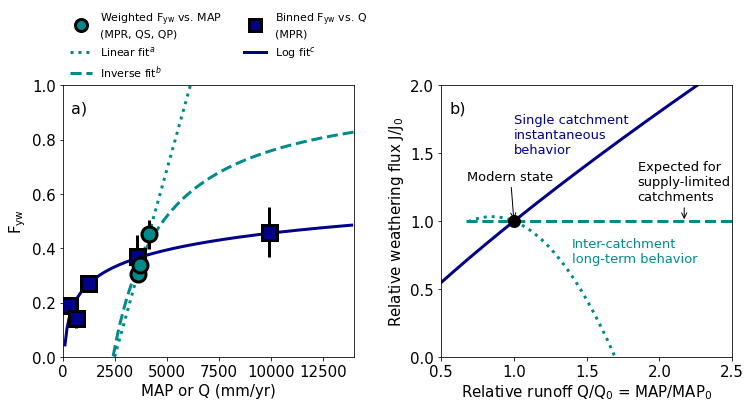

In [17]:
### now: plot predictions using Fyw-Q and Fyw-MAP relationships
# modern MAP
MAPmodern = df.loc['MPR','Pmean']

plt.rcParams.update({'font.size': 13,
                    'axes.labelsize': 15,
                    'xtick.labelsize':15,
                    'ytick.labelsize':15})

### start out by plotting inter-catchment differences in Fyw vs. MAP (long term behavior)
fig,ax=plt.subplots(1,2,figsize=(12,5))
for s in ['MPR','QS','QP']:
    if s=='MPR':
        label='Weighted F$_{\mathrm{yw}}$ vs. MAP'
    else:
        label = '_nolegend_'
    
    ax[0].errorbar(df.loc[s,'Pmean'],df.loc[s,'ampratio'],yerr=df.loc[s,'ampratio_error'],c='k',markerfacecolor='darkcyan',marker='o',lw=3,markeredgewidth=3,markersize=15,label=label,ls='')

# make labels for fits equaitons
fitlabels = ['Linear fit$^{a}$','Inverse fit$^{b}$','Log fit$^{c}$']

# plotx
plotx_short = np.arange(100,14000,10)
plotx_long = np.arange(100,14000,100)

# for a relationship of 1-Fyw = 1/MAP, calculate MAP*(1-Fyw) for all VC sites
a_over = np.nanmean((df.loc[['MPR','QP','QS'],'Pmean'])*(1-df.loc[['MPR','QP','QS'],'ampratio']))
# what about linear relationship?
res_map_linear = stats.linregress(df.loc[['MPR','QP','QS'],'Pmean'],df.loc[['MPR','QP','QS'],'ampratio'])

# make relationships for plotting along plotx
fyw_map_linear = plotx_short*res_map_linear.slope+res_map_linear.intercept
fyw_map_1over = 1-(1/plotx_short)*a_over

# cant have fyw<0, >1, replace with nan
fyw_map_linear[((fyw_map_linear<0)|(fyw_map_linear>1))] = np.nan
fyw_map_1over[((fyw_map_1over<0)|(fyw_map_1over>1))] = np.nan

# compute fywmean
fyw_map_mean_linear = MAPmodern*res_map_linear.slope+res_map_linear.intercept
fyw_map_mean_1over = 1-(1/MAPmodern)*a_over

# plot
ax[0].plot(plotx_short,fyw_map_linear,label=fitlabels[0],c='darkcyan',ls=':',lw=3,zorder=0)
ax[0].plot(plotx_short,fyw_map_1over,label=fitlabels[1],c='darkcyan',ls='--',lw=3,zorder=0)

ax[1].plot(plotx_short/MAPmodern,(1-fyw_map_linear)*plotx_short/(MAPmodern*(1-fyw_map_mean_linear)),c='darkcyan',ls=':',lw=3,zorder=0)
ax[1].plot(plotx_short/MAPmodern,(1-fyw_map_1over)*plotx_short/(MAPmodern*(1-fyw_map_mean_1over)),c='darkcyan',ls='--',lw=3,zorder=0)


### now evaluate single catchment Fyw behavior
tempdf = perc_df.loc[perc_df['site']=='MPR',:]
x = df_medians.loc[s,['0-25_sp','25-50_sp','50-75_sp','75-100_sp','90-100_sp']]*1000 # convert m/yr to mm/yr
y = tempdf['ampratio']

ax[0].errorbar(x,y,yerr=tempdf['ampratio_error'],c='k',markerfacecolor=pp.color['MPR'],lw=3,markeredgewidth=3,zorder=1,ls='',marker='s',markersize=15,label='Binned F$_{\mathrm{yw}}$ vs. Q')

# now extrapolate using linear or log relationship between MPR binned Fyw and Q
# do regression
res_q_linear = stats.linregress(x,y)
res_q_log = stats.linregress(np.log(x),y)
# make predictoin
fyw_q_linear = plotx_long*res_q_linear.slope+res_q_linear.intercept
fyw_q_log = np.log(plotx_long)*res_q_log.slope+res_q_log.intercept
# compute mean for MAP modern
fyw_q_linear_mean = MAPmodern*res_q_linear.slope+res_q_linear.intercept
fyw_q_log_mean = np.log(MAPmodern)*res_q_log.slope+res_q_log.intercept

# plot Fyw vs. Q, expected weathering flux
ax[0].plot(plotx_long,fyw_q_log,label=fitlabels[2],zorder=0,c=pp.color['MPR'],lw=3)
ax[1].plot(plotx_long/MAPmodern,plotx_long*(1-fyw_q_log)/(MAPmodern*(1-fyw_q_log_mean)),c=pp.color['MPR'],lw=3)

# now annotate
ax[1].plot(1,1,c='k',markersize=10,ls='',marker='o',markeredgewidth=3)
ax[1].annotate('Modern state',(1,1),xytext=(0.68,1.3),arrowprops=dict(arrowstyle='->'))
ax[1].annotate('Expected for \nsupply-limited\ncatchments',(2.17,1),xytext=(1.85,1.15),arrowprops=dict(arrowstyle='->'))
    


## now limits, labels 
ax[0].set_xlim([-10,14000])
ax[0].set_ylim([0,1])

ax[1].set_xlim([0.5,2.5])
ax[1].set_ylim([0,2])

ax[1].set_xticks([0.5,1,1.5,2,2.5])
ax[1].set_yticks([0,0.5,1,1.5,2])

ax[0].set_xlabel('MAP or Q (mm/yr)')
ax[0].set_ylabel('F$_{\mathrm{yw}}$')
    
ax[1].set_xlabel('Relative runoff Q/Q$_{0}$ = MAP/MAP$_{0}$')
ax[1].set_ylabel('Relative weathering flux J/J$_{0}$')

# legend
ax[0].legend()


### make labels
# make some room
fig.subplots_adjust(wspace=0.3)

fitlabels = ['Linear fit$^{a}$','Inverse fit$^{b}$','Log fit$^{c}$']

legend_both = [Line2D([0], [0],ls='',c='k',markerfacecolor='darkcyan',marker='o',lw=3,markeredgewidth=3,markersize=12,label='Weighted F$_{\mathrm{yw}}$ vs. MAP\n(MPR, QS, QP)'),
                   Line2D([0], [0],label=fitlabels[0],c='darkcyan',ls=':',lw=3),
                   Line2D([0], [0],label=fitlabels[1],c='darkcyan',ls='--',lw=3),
#                Line2D([0], [0],label='',c='none'),
               Line2D([0], [0],ls='',c='k',markerfacecolor=pp.color['MPR'],marker='s',lw=3,markeredgewidth=3,markersize=12,label='Binned F$_{\mathrm{yw}}$ vs. Q\n(MPR)'),
                   Line2D([0], [0],label=fitlabels[2],c=pp.color['MPR'],lw=3)]

legend =  ax[0].legend(handles=legend_both,bbox_to_anchor=[1.08,1.31],frameon=False,ncol=2,fontsize=11)
# legend =  ax[0].legend(handles=legend_both,loc='lower right',frameon=False,ncol=1,fontsize=12,labelspacing=0.2,borderpad=0)

## label things... need to rearrange because I want the errorbar before lines, default plot order is reverse.
# I also wanted to add subtitles for each column

ax[1].text(0.45,0.35,"Inter-catchment\nlong-term behavior",transform=ax[1].transAxes,c='darkcyan')
ax[1].text(0.25,0.75,"Single catchment\ninstantaneous\nbehavior",transform=ax[1].transAxes,c=pp.color['MPR'])
                       
ax[0].text(0.03,0.90,'a)',transform=ax[0].transAxes,fontsize=16)
ax[1].text(0.03,0.90,'b)',transform=ax[1].transAxes,fontsize=16)

fig.savefig('plots/Fig10_prediction.pdf',bbox_inches='tight')

REFERENCES:

Wymore, A. S., Brereton, R. L., Ibarra, D. E., Maher, K., & McDowell, W. H. (2017). Critical zone structure controls concentration‐discharge relationships and solute generation in forested tropical montane watersheds. Water Resources Research, 53(7), 6279-6295.

West, A. J., Galy, A., & Bickle, M. (2005). Tectonic and climatic controls on silicate weathering. Earth and Planetary Science Letters, 235(1-2), 211-228.

Moore, A. K., Méndez Méndez, K., Hughes, K. S., & Granger, D. E. (2024). Volcanic arc weathering rates in the humid tropics controlled by the interplay between physical erosion and precipitation. AGU Advances, 5(2), e2023AV001066.

Brocard, G. Y., Willenbring, J. K., Scatena, F. N., & Johnson, A. H. (2015). Effects of a tectonically-triggered wave of incision on riverine exports and soil mineralogy in the Luquillo Mountains of Puerto Rico. Applied Geochemistry, 63, 586-598.

Stallard, R. F. (2012). Weathering, landscape equilibrium, and carbon in four watersheds in eastern Puerto Rico: Chapter H in Water quality and landscape processes of four watersheds in eastern Puerto Rico (No. 1789-H, pp. 199-248). US Geological Survey.

Turner, B. F., Stallard, R. F., & Brantley, S. L. (2003). Investigation of in situ weathering of quartz diorite bedrock in the Rio Icacos basin, Luquillo Experimental Forest, Puerto Rico. Chemical Geology, 202(3-4), 313-341.